### Infogroup validation against ACS at household level
#### Region: Puget Sound

Author: Shayan Ghosh <br>
Email: shayan.ghosh@berkeley.edu <br>
Date created: November 5, 2020 <br>

In [78]:
import dask.dataframe as dd
import pandas as pd
from sklearn.feature_extraction import DictVectorizer
import os

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [79]:
from dask.distributed import Client, LocalCluster

# client = LocalCluster( scheduler_port = 8785 , n_workers = 4 )
client = Client(n_workers=32)

/users/spghosh/anaconda3/lib/python3.8/site-packages/distributed/node.py:151: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33567 instead
  warnings.warn(


In [80]:
client

<Client: 'tcp://127.0.0.1:42843' processes=32 threads=32, memory=134.92 GB>

### Set Year

In [137]:
YEAR = 2014

In [138]:
!pwd

/users/spghosh/hprm/code/IG_validation/output/acs_puget_2015


In [139]:
os.chdir('/data/infogroup/raw')

In [140]:
!pwd

/data/infogroup/raw


In [141]:
!ls 

dask-worker-space	     US_Consumer_5_File_2012.csv
ethnicity_coding.csv	     US_Consumer_5_File_2013.csv
infogroup_puget2015.csv      US_Consumer_5_File_2014.csv
US_Consumer_5_File_2006.csv  US_Consumer_5_File_2015.csv
US_Consumer_5_File_2007.csv  US_Consumer_5_File_2016.csv
US_Consumer_5_File_2008.csv  US_Consumer_5_File_2017.csv
US_Consumer_5_File_2009.csv  US_Consumer_5_File_2018.csv
US_Consumer_5_File_2010.csv  US_Consumer_5_File_2019.csv
US_Consumer_5_File_2011.csv


# Part 1: Preparing IG Data

In [142]:
def load_ig(columns, year):
    # Load in df
    all_cols = ['FAMILYID', 'DOWNGRADE_REASON_CODE', 'DOWNGRADE_DATE', 'RECENCY_DATE',
       'LOCATION_TYPE', 'PRIMARY_FAMILY_IND', 'HOUSEHOLDSTATUS',
       'TRADELINE_COUNT', 'HEAD_HH_AGE_CODE', 'LENGTH_OF_RESIDENCE',
       'CHILDRENHHCOUNT', 'CHILDREN_IND', 'ADDRESSTYPE', 'MAILABILITY_SCORE',
       'WEALTH_FINDER_SCORE', 'FIND_DIV_1000', 'OWNER_RENTER_STATUS',
       'ESTMTD_HOME_VAL_DIV_1000', 'MARITAL_STATUS', 'PPI_DIV_1000',
       'MSA2000_CODE', 'MSA2000_IDENTIFIER', 'CSA2000_CODE', 'CBSACODE',
       'CBSATYPE', 'CSACODE', 'LOCATIONID', 'HOUSE_NUM', 'HOUSE_NUM_FRACTION',
       'STREET_PRE_DIR', 'STREET_NAME', 'STREET_POST_DIR', 'STREET_SUFFIX',
       'UNIT_TYPE', 'UNIT_NUM', 'BOX_TYPE', 'BOX_NUM', 'ROUTE_TYPE',
       'ROUTE_NUM', 'CITY', 'STATE', 'ZIP', 'ZIP4', 'DPBC', 'VACANT',
       'USPSNOSTATS', 'GE_LATITUDE_2010', 'GE_LONGITUDE_2010',
       'GE_CENSUS_LEVEL_2010', 'GE_CENSUS_STATE_2010', 'GE_CENSUS_COUNTY',
       'GE_CENSUS_TRACT', 'GE_CENSUS_BG', 'GE_ALS_COUNTY_CODE_2010',
       'GE_ALS_CENSUS_TRACT_2010', 'GE_ALS_CENSUS_BG_2010', 'Individualid_1',
       'first_name_1', 'middle_name_1', 'last_name_1', 'suffix_code_1',
       'gender_1', 'Ethnicity_Code_1', 'Individualid_2', 'first_name_2',
       'middle_name_2', 'last_name_2', 'suffix_code_2', 'gender_2',
       'Ethnicity_Code_2', 'Individualid_3', 'first_name_3', 'middle_name_3',
       'last_name_3', 'suffix_code_3', 'gender_3', 'Ethnicity_Code_3',
       'Individualid_4', 'first_name_4', 'middle_name_4', 'last_name_4',
       'suffix_code_4', 'gender_4', 'Ethnicity_Code_4', 'Individualid_5',
       'first_name_5', 'middle_name_5', 'last_name_5', 'suffix_code_5',
       'gender_5', 'Ethnicity_Code_5']
    dtypes = dict(zip(all_cols, [np.str] * len(all_cols)))
    df = dd.read_csv('US_Consumer_5_File_' + str(year) +'.csv', dtype=dtypes)[columns]
    df = client.persist(df)
    return df

ig_columns = [ 'FAMILYID', 'FIND_DIV_1000', 'OWNER_RENTER_STATUS',
       'GE_CENSUS_STATE_2010', 'GE_CENSUS_COUNTY',
       'GE_ALS_CENSUS_TRACT_2010', 'Ethnicity_Code_1'
]

ig_puget = load_ig(ig_columns, YEAR)
ig_puget.head()

distributed.scheduler - ERROR - Couldn't gather keys {"('head-1-5-getitem-fc3f6063bacbdeabc604c7d23d8819ff', 0)": ['tcp://127.0.0.1:44441']} state: ['memory'] workers: ['tcp://127.0.0.1:44441']
NoneType: None
distributed.scheduler - ERROR - Workers don't have promised key: ['tcp://127.0.0.1:44441'], ('head-1-5-getitem-fc3f6063bacbdeabc604c7d23d8819ff', 0)
NoneType: None
distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('head-1-5-getitem-fc3f6063bacbdeabc604c7d23d8819ff', 0)": ('tcp://127.0.0.1:44441',)}


FAMILYID FIND_DIV_1000 OWNER_RENTER_STATUS GE_CENSUS_STATE_2010  \
0  000000009008           018                   8                   05   
1  000000009184           181                   9                   28   
2  000000009391           062                   9                   48   
3  000000009414           020                   7                   05   
4  000000009503           019                   9                   05   

  GE_CENSUS_COUNTY GE_ALS_CENSUS_TRACT_2010 Ethnicity_Code_1  
0              079                   960300               E5  
1              033                   071000               E5  
2              367                   140501               FR  
3              079                   960300               LR  
4              069                   002500               LR

In [143]:
ig_puget

Dask DataFrame Structure:
                FAMILYID FIND_DIV_1000 OWNER_RENTER_STATUS GE_CENSUS_STATE_2010 GE_CENSUS_COUNTY GE_ALS_CENSUS_TRACT_2010 Ethnicity_Code_1
npartitions=704                                                                                                                           
                  object        object              object               object           object                   object           object
                     ...           ...                 ...                  ...              ...                      ...              ...
...                  ...           ...                 ...                  ...              ...                      ...              ...
                     ...           ...                 ...                  ...              ...                      ...              ...
                     ...           ...                 ...                  ...              ...                      ...              ...
Dask Name: getitem, 704 tasks

In [144]:
def narrow_puget(df):
    # narrow to Puget Sound
    puget_counties = ['53033', '53053', '53061']
    county_series = df.GE_CENSUS_STATE_2010 + df.GE_CENSUS_COUNTY
    df = df[county_series.isin(puget_counties)]
    df = client.persist(df)
    
    # Attempt to improve performance THIS WILL TAKE A WHILE
#     df = df.set_index('FAMILYID')
    df = df.repartition(npartitions=df.npartitions // 100)
    
    # Add GEOID10 variable
    df['GEOID10'] = df.GE_CENSUS_STATE_2010 + df.GE_CENSUS_COUNTY + df.GE_ALS_CENSUS_TRACT_2010
    df = df.drop(labels=['GE_CENSUS_STATE_2010', 'GE_CENSUS_COUNTY', 'GE_ALS_CENSUS_TRACT_2010'], axis=1)
    df = client.persist(df)
    return df

ig_puget = narrow_puget(ig_puget)
ig_puget.head()

FAMILYID FIND_DIV_1000 OWNER_RENTER_STATUS Ethnicity_Code_1  \
8194   000000399180           140                   9               00   
8702   000000409701           095                   9               IE   
13408  000000624553           275                   9               PL   
15866  000000843082           058                   9               E5   
17531  000000938515           032                   4               IE   

           GEOID10  
8194   53033030100  
8702   53033029602  
13408  53061000000  
15866  53033000000  
17531  53033029306


#### The above cell may take up to an hour to run, but the remaining cells will be much faster because of it

It not only reduced the number of rows, but it reduced the number of partitions from 781 to 7

In [145]:
ig_puget

Dask DataFrame Structure:
              FAMILYID FIND_DIV_1000 OWNER_RENTER_STATUS Ethnicity_Code_1 GEOID10
npartitions=7                                                                    
                object        object              object           object  object
                   ...           ...                 ...              ...     ...
...                ...           ...                 ...              ...     ...
                   ...           ...                 ...              ...     ...
                   ...           ...                 ...              ...     ...
Dask Name: drop_by_shallow_copy, 7 tasks

In [146]:
def fix_income(df):
    df['Income'] = df['FIND_DIV_1000'].astype(int) * 1000
    df = df.drop(labels='FIND_DIV_1000', axis=1)
    df = client.persist(df)
    return df

ig_puget = fix_income(ig_puget)
ig_puget.head()

FAMILYID OWNER_RENTER_STATUS Ethnicity_Code_1      GEOID10  Income
8194   000000399180                   9               00  53033030100  140000
8702   000000409701                   9               IE  53033029602   95000
13408  000000624553                   9               PL  53061000000  275000
15866  000000843082                   9               E5  53033000000   58000
17531  000000938515                   4               IE  53033029306   32000

In [147]:
def set_renter(df):
    df['Renter'] = (df['OWNER_RENTER_STATUS'].astype(int) < 4).astype(int)
    df = df.drop(labels='OWNER_RENTER_STATUS', axis=1)
    df = client.persist(df)
    return df

ig_puget = set_renter(ig_puget)
ig_puget.head()

FAMILYID Ethnicity_Code_1      GEOID10  Income  Renter
8194   000000399180               00  53033030100  140000       0
8702   000000409701               IE  53033029602   95000       0
13408  000000624553               PL  53061000000  275000       0
15866  000000843082               E5  53033000000   58000       0
17531  000000938515               IE  53033029306   32000       0

In [148]:
def ethnic_coding(df):
    # fix ethnic coding
    ethnicity = pd.read_csv('ethnicity_coding.csv')[['INFOGROUP_CODE', 'RACE']].groupby('INFOGROUP_CODE').agg(max).RACE.to_dict()
    df['Race'] = df['Ethnicity_Code_1'].replace(ethnicity)
    df = df.drop(labels='Ethnicity_Code_1', axis=1)
    df = client.persist(df)
    return df

ig_puget = ethnic_coding(ig_puget)
ig_puget.head()

FAMILYID      GEOID10  Income  Renter     Race
8194   000000399180  53033030100  140000       0  UNKNOWN
8702   000000409701  53033029602   95000       0    WHITE
13408  000000624553  53061000000  275000       0    WHITE
15866  000000843082  53033000000   58000       0    WHITE
17531  000000938515  53033029306   32000       0    WHITE

In [149]:
ig_puget.size.compute()

8738070

## Convert ig_puget to a pandas dataframe 
- drastically increases functionality and speed

In [150]:
ig_puget = ig_puget.compute()
ig_puget.head()

FAMILYID      GEOID10  Income  Renter     Race
8194   000000399180  53033030100  140000       0  UNKNOWN
8702   000000409701  53033029602   95000       0    WHITE
13408  000000624553  53061000000  275000       0    WHITE
15866  000000843082  53033000000   58000       0    WHITE
17531  000000938515  53033029306   32000       0    WHITE

In [151]:
ig_puget.size

8738070

In [152]:
def one_hot_ethnicity(data):
    """
    Return the one-hot encoded dataframe of our input data.
    
    Parameters
    -----------
    data: a dataframe that may include non-numerical features (RACE)
    
    Returns
    -----------
    A one-hot encoded dataframe that only contains numeric features
    
    """
    # From lab section 11-12 10/26/20
    cols = ['Race']
    v = DictVectorizer()
    v.fit(data[cols].to_dict(orient='records'))
    cat_data = v.transform(data[cols].to_dict(orient='records')).toarray()
    cd_names = v.get_feature_names() #cols for cat_data columns
    cat_data = pd.DataFrame(cat_data, columns=cd_names)
    data = data.drop(columns='Race').reset_index()
    return pd.concat([data, cat_data], axis = 1)

ig_puget = one_hot_ethnicity(ig_puget)
ig_puget.head()

index      FAMILYID      GEOID10  Income  Renter  Race  Race=ASIAN  \
0   8194  000000399180  53033030100  140000       0   0.0         0.0   
1   8702  000000409701  53033029602   95000       0   0.0         0.0   
2  13408  000000624553  53061000000  275000       0   0.0         0.0   
3  15866  000000843082  53033000000   58000       0   0.0         0.0   
4  17531  000000938515  53033029306   32000       0   0.0         0.0   

   Race=BLACK  Race=LATINX  Race=OTHER  Race=UNKNOWN  Race=WHITE  
0         0.0          0.0         0.0           1.0         0.0  
1         0.0          0.0         0.0           0.0         1.0  
2         0.0          0.0         0.0           0.0         1.0  
3         0.0          0.0         0.0           0.0         1.0  
4         0.0          0.0         0.0           0.0         1.0

### Moment of truth: grouping time

In [153]:
def ig_agg(df):
    # Drop unnecessary variables
    if 'index' in list(df.columns):
        df.drop(columns='index', inplace=True)
    if 'FAMILYID' in list(df.columns):
        df.drop(columns='FAMILYID', inplace=True)
    if 'Race' in list(df.columns):
        df.drop(columns='Race', inplace=True)
    # Set variables to float
    for col in list(df.columns):
        if col != 'GEOID10':
            df[col] = df[col].astype(float)                
    # Group by tract
    func_mapper = {
        'Income': 'median',
        'Renter': 'sum',
        'Race=ASIAN': 'sum',
        'Race=BLACK': 'sum',
        'Race=LATINX': 'sum',
        'Race=OTHER': 'sum',
        'Race=UNKNOWN': 'sum',
        'Race=WHITE': 'sum',
        
    }
    df = df.groupby('GEOID10').agg(func_mapper)
    return df

ig_geoid = ig_agg(ig_puget)
ig_geoid.head()

Income   Renter  Race=ASIAN  Race=BLACK  Race=LATINX  \
GEOID10                                                              
53033000000  50000.0  30097.0     20395.0      2990.0      12643.0   
53033000100  20000.0    765.0       116.0        36.0         63.0   
53033000200  37000.0    317.0       176.0        38.0         75.0   
53033000300  45000.0    104.0       127.0        28.0         78.0   
53033000401  12000.0   1862.0       269.0        96.0        171.0   

             Race=OTHER  Race=UNKNOWN  Race=WHITE  
GEOID10                                            
53033000000       418.0       20583.0    182104.0  
53033000100         3.0         118.0       837.0  
53033000200         1.0         132.0       940.0  
53033000300         5.0          96.0       845.0  
53033000401         3.0         261.0      2107.0

In [154]:
# Renaming Variables
name_mapper = {'Income':'Median_Income', 'Renter':'Num_Renters'}
ig_geoid.rename(columns=name_mapper, inplace=True)
ig_geoid.head()

Median_Income  Num_Renters  Race=ASIAN  Race=BLACK  Race=LATINX  \
GEOID10                                                                        
53033000000        50000.0      30097.0     20395.0      2990.0      12643.0   
53033000100        20000.0        765.0       116.0        36.0         63.0   
53033000200        37000.0        317.0       176.0        38.0         75.0   
53033000300        45000.0        104.0       127.0        28.0         78.0   
53033000401        12000.0       1862.0       269.0        96.0        171.0   

             Race=OTHER  Race=UNKNOWN  Race=WHITE  
GEOID10                                            
53033000000       418.0       20583.0    182104.0  
53033000100         3.0         118.0       837.0  
53033000200         1.0         132.0       940.0  
53033000300         5.0          96.0       845.0  
53033000401         3.0         261.0      2107.0

#### At this point, code has already been running for approximately 40 years, so I'll save the current form of IG here

In [155]:
# ig_geoid.to_csv('infogroup_puget' + str(YEAR) + '.csv')

In [156]:
# ig_geoid = pd.read_csv('infogroup_puget' + str(YEAR) + '.csv', dtype={'GEOID10':np.str})

In [157]:
ig_geoid.head()

GEOID10  Median_Income  Num_Renters  Race=ASIAN  Race=BLACK  \
0  53033000000        50000.0      30097.0     20395.0      2990.0   
1  53033000100        20000.0        765.0       116.0        36.0   
2  53033000200        37000.0        317.0       176.0        38.0   
3  53033000300        45000.0        104.0       127.0        28.0   
4  53033000401        12000.0       1862.0       269.0        96.0   

   Race=LATINX  Race=OTHER  Race=UNKNOWN  Race=WHITE  
0      12643.0       418.0       20583.0    182104.0  
1         63.0         3.0         118.0       837.0  
2         75.0         1.0         132.0       940.0  
3         78.0         5.0          96.0       845.0  
4        171.0         3.0         261.0      2107.0

In [159]:
ig_geoid.drop(columns=['Race=OTHER', 'Race=UNKNOWN'], inplace=True)
ig_geoid.head()

GEOID10  Median_Income  Num_Renters  Race=ASIAN  Race=BLACK  \
0  53033000000        50000.0      30097.0     20395.0      2990.0   
1  53033000100        20000.0        765.0       116.0        36.0   
2  53033000200        37000.0        317.0       176.0        38.0   
3  53033000300        45000.0        104.0       127.0        28.0   
4  53033000401        12000.0       1862.0       269.0        96.0   

   Race=LATINX  Race=WHITE  
0      12643.0    182104.0  
1         63.0       837.0  
2         75.0       940.0  
3         78.0       845.0  
4        171.0      2107.0

In [160]:
ig_geoid['ig_count'] = ig_geoid['Race=ASIAN'] + ig_geoid['Race=BLACK'] + ig_geoid['Race=LATINX'] + ig_geoid['Race=WHITE']
ig_geoid.head()

GEOID10  Median_Income  Num_Renters  Race=ASIAN  Race=BLACK  \
0  53033000000        50000.0      30097.0     20395.0      2990.0   
1  53033000100        20000.0        765.0       116.0        36.0   
2  53033000200        37000.0        317.0       176.0        38.0   
3  53033000300        45000.0        104.0       127.0        28.0   
4  53033000401        12000.0       1862.0       269.0        96.0   

   Race=LATINX  Race=WHITE  ig_count  
0      12643.0    182104.0  218132.0  
1         63.0       837.0    1052.0  
2         75.0       940.0    1229.0  
3         78.0       845.0    1078.0  
4        171.0      2107.0    2643.0

# Part 2: Preparing ACS Data

In [161]:
os.chdir('/data/acs_raw')

In [162]:
!ls

census_wide_all.csv  census_wide_race_hh.csv  ig_validate_2015.csv


In [163]:
def load_acs(year):
    acs = pd.read_csv("census_wide_all.csv", dtype={'geoid': np.str})
    acs_hh = acs_hh = pd.read_csv("census_wide_race_hh.csv", dtype={'geoid': np.str})
    joint = acs[acs.year == year].merge(acs_hh[acs_hh.year == year], on="geoid")
    relevant_cols = ['geoid', 'hh_count', 'renter_count', 'medinc', 'white_hh', 'black_hh', 'asian_hh', 'hisp_hh']
    return joint[relevant_cols]

acs = load_acs(2018)
acs.head()

geoid  hh_count  renter_count   medinc  white_hh  black_hh  asian_hh  \
0  01001020100       765           195  58625.0       622        73         0   
1  01001020200       719           255  43531.0       274       441         4   
2  01001020300      1296           455  51875.0       876       353        12   
3  01001020400      1639           377  54050.0      1487       126         0   
4  01001020500      4174          1853  72417.0      3251       700       150   

   hisp_hh  
0       56  
1        0  
2       23  
3       16  
4       73

In [164]:
pd.read_csv("census_wide_all.csv", dtype={'geoid': np.str}).year.value_counts()

2010    73057
2018    73056
2012    73056
2009    65461
Name: year, dtype: int64

In [165]:
def puget_acs(df):
    puget_counties = ['53033', '53053', '53061']
    df = df = df[df.geoid.str.slice(stop=5).isin(puget_counties)]
    return df

acs = puget_acs(acs)
acs.head()

geoid  hh_count  renter_count   medinc  white_hh  black_hh  \
69874  53033000100      3899          2837  50948.0      2351       537   
69875  53033000200      3693          1638  69790.0      2607       242   
69876  53033000300      1159           400  86696.0       877        42   
69877  53033000401      3842          2862  32262.0      2558       478   
69878  53033000402      2373          1380  73792.0      1931        78   

       asian_hh  hisp_hh  
69874       586      224  
69875       400      272  
69876       160       31  
69877       440      132  
69878       136      135

# Part 3: Merging Tables

In [166]:
acs.head()

geoid  hh_count  renter_count   medinc  white_hh  black_hh  \
69874  53033000100      3899          2837  50948.0      2351       537   
69875  53033000200      3693          1638  69790.0      2607       242   
69876  53033000300      1159           400  86696.0       877        42   
69877  53033000401      3842          2862  32262.0      2558       478   
69878  53033000402      2373          1380  73792.0      1931        78   

       asian_hh  hisp_hh  
69874       586      224  
69875       400      272  
69876       160       31  
69877       440      132  
69878       136      135

In [167]:
ig_geoid.head()

GEOID10  Median_Income  Num_Renters  Race=ASIAN  Race=BLACK  \
0  53033000000        50000.0      30097.0     20395.0      2990.0   
1  53033000100        20000.0        765.0       116.0        36.0   
2  53033000200        37000.0        317.0       176.0        38.0   
3  53033000300        45000.0        104.0       127.0        28.0   
4  53033000401        12000.0       1862.0       269.0        96.0   

   Race=LATINX  Race=WHITE  ig_count  
0      12643.0    182104.0  218132.0  
1         63.0       837.0    1052.0  
2         75.0       940.0    1229.0  
3         78.0       845.0    1078.0  
4        171.0      2107.0    2643.0

In [168]:
together = ig_geoid.merge(right=acs, left_on='GEOID10', right_on='geoid', how='inner')#.drop(columns=['geoid'])
together.head()

GEOID10  Median_Income  Num_Renters  Race=ASIAN  Race=BLACK  \
0  53033000100        20000.0        765.0       116.0        36.0   
1  53033000200        37000.0        317.0       176.0        38.0   
2  53033000300        45000.0        104.0       127.0        28.0   
3  53033000401        12000.0       1862.0       269.0        96.0   
4  53033000402        32000.0        679.0       115.0        48.0   

   Race=LATINX  Race=WHITE  ig_count        geoid  hh_count  renter_count  \
0         63.0       837.0    1052.0  53033000100      3899          2837   
1         75.0       940.0    1229.0  53033000200      3693          1638   
2         78.0       845.0    1078.0  53033000300      1159           400   
3        171.0      2107.0    2643.0  53033000401      3842          2862   
4        110.0      1602.0    1875.0  53033000402      2373          1380   

    medinc  white_hh  black_hh  asian_hh  hisp_hh  
0  50948.0      2351       537       586      224  
1  69790.0      2607       242       400      272  
2  86696.0       877        42       160       31  
3  32262.0      2558       478       440      132  
4  73792.0      1931        78       136      135

In [169]:
new_cols = {
    'Median_Income':'ig_medinc',
    'medinc':'acs_medinc',
    'Num_Renters':'ig_renters',
    'renter_count':'acs_renters',
    'Race=ASIAN':'ig_asian',
    'asian_hh':'acs_asian',
    'Race=BLACK':'ig_black',
    'black_hh':'acs_black',
    'Race=LATINX':'ig_latinx',
    'hisp_hh':'acs_hispanic',
    'Race=WHITE':'ig_white',
    'white_hh':'acs_white',
    'hh_count':'acs_count',
}
together.rename(columns=new_cols, inplace=True)
together.head()

GEOID10  ig_medinc  ig_renters  ig_asian  ig_black  ig_latinx  \
0  53033000100    20000.0       765.0     116.0      36.0       63.0   
1  53033000200    37000.0       317.0     176.0      38.0       75.0   
2  53033000300    45000.0       104.0     127.0      28.0       78.0   
3  53033000401    12000.0      1862.0     269.0      96.0      171.0   
4  53033000402    32000.0       679.0     115.0      48.0      110.0   

   ig_white  ig_count        geoid  acs_count  acs_renters  acs_medinc  \
0     837.0    1052.0  53033000100       3899         2837     50948.0   
1     940.0    1229.0  53033000200       3693         1638     69790.0   
2     845.0    1078.0  53033000300       1159          400     86696.0   
3    2107.0    2643.0  53033000401       3842         2862     32262.0   
4    1602.0    1875.0  53033000402       2373         1380     73792.0   

   acs_white  acs_black  acs_asian  acs_hispanic  
0       2351        537        586           224  
1       2607        242        400           272  
2        877         42        160            31  
3       2558        478        440           132  
4       1931         78        136           135

In [170]:
col_order = ['geoid', 'ig_count', 'acs_count', 'ig_medinc', 'acs_medinc', 'ig_renters', 'acs_renters', 'ig_asian', 'acs_asian', 
             'ig_black', 'acs_black', 'ig_latinx', 'acs_hispanic', 'ig_white', 'acs_white']
together = together[col_order]
together.head()

geoid  ig_count  acs_count  ig_medinc  acs_medinc  ig_renters  \
0  53033000100    1052.0       3899    20000.0     50948.0       765.0   
1  53033000200    1229.0       3693    37000.0     69790.0       317.0   
2  53033000300    1078.0       1159    45000.0     86696.0       104.0   
3  53033000401    2643.0       3842    12000.0     32262.0      1862.0   
4  53033000402    1875.0       2373    32000.0     73792.0       679.0   

   acs_renters  ig_asian  acs_asian  ig_black  acs_black  ig_latinx  \
0         2837     116.0        586      36.0        537       63.0   
1         1638     176.0        400      38.0        242       75.0   
2          400     127.0        160      28.0         42       78.0   
3         2862     269.0        440      96.0        478      171.0   
4         1380     115.0        136      48.0         78      110.0   

   acs_hispanic  ig_white  acs_white  
0           224     837.0       2351  
1           272     940.0       2607  
2            31     845.0        877  
3           132    2107.0       2558  
4           135    1602.0       1931

In [171]:
together.set_index('geoid', inplace=True)
together.head()

ig_count  acs_count  ig_medinc  acs_medinc  ig_renters  \
geoid                                                                 
53033000100    1052.0       3899    20000.0     50948.0       765.0   
53033000200    1229.0       3693    37000.0     69790.0       317.0   
53033000300    1078.0       1159    45000.0     86696.0       104.0   
53033000401    2643.0       3842    12000.0     32262.0      1862.0   
53033000402    1875.0       2373    32000.0     73792.0       679.0   

             acs_renters  ig_asian  acs_asian  ig_black  acs_black  ig_latinx  \
geoid                                                                           
53033000100         2837     116.0        586      36.0        537       63.0   
53033000200         1638     176.0        400      38.0        242       75.0   
53033000300          400     127.0        160      28.0         42       78.0   
53033000401         2862     269.0        440      96.0        478      171.0   
53033000402         1380     115.0        136      48.0         78      110.0   

             acs_hispanic  ig_white  acs_white  
geoid                                           
53033000100           224     837.0       2351  
53033000200           272     940.0       2607  
53033000300            31     845.0        877  
53033000401           132    2107.0       2558  
53033000402           135    1602.0       1931

In [172]:
# together.to_csv('ig_validate_' + str(YEAR) + '.csv')

In [173]:
# together = pd.read_csv('ig_validate_' + str(YEAR) + '.csv', dtype={'geoid':np.str})
together.head()

ig_count  acs_count  ig_medinc  acs_medinc  ig_renters  \
geoid                                                                 
53033000100    1052.0       3899    20000.0     50948.0       765.0   
53033000200    1229.0       3693    37000.0     69790.0       317.0   
53033000300    1078.0       1159    45000.0     86696.0       104.0   
53033000401    2643.0       3842    12000.0     32262.0      1862.0   
53033000402    1875.0       2373    32000.0     73792.0       679.0   

             acs_renters  ig_asian  acs_asian  ig_black  acs_black  ig_latinx  \
geoid                                                                           
53033000100         2837     116.0        586      36.0        537       63.0   
53033000200         1638     176.0        400      38.0        242       75.0   
53033000300          400     127.0        160      28.0         42       78.0   
53033000401         2862     269.0        440      96.0        478      171.0   
53033000402         1380     115.0        136      48.0         78      110.0   

             acs_hispanic  ig_white  acs_white  
geoid                                           
53033000100           224     837.0       2351  
53033000200           272     940.0       2607  
53033000300            31     845.0        877  
53033000401           132    2107.0       2558  
53033000402           135    1602.0       1931

# Part 4: Visualization

In [174]:
os.chdir('/users/spghosh/hprm/code/IG_validation/output/')
!mkdir acs_puget_2014 # ADJUST
!ls

acs_puget_2014	acs_puget_2016	acs_puget_2018
acs_puget_2015	acs_puget_2017	acs_puget_2019


In [175]:
os.chdir('/users/spghosh/hprm/code/IG_validation/output/acs_puget_' + str(YEAR))

In [176]:
!pwd

/users/spghosh/hprm/code/IG_validation/output/acs_puget_2014


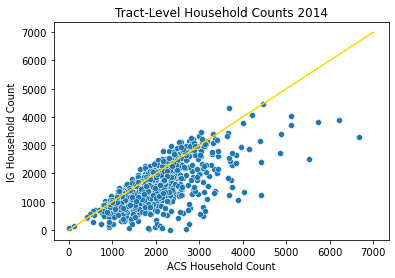

In [177]:
plt.title('Tract-Level Household Counts ' + str(YEAR))
plt.xlabel('ACS Household Count')
plt.ylabel('IG Household Count')
x = np.linspace(0, 7000, 10000)
plt.plot(x, x, color='gold');
fig = sns.scatterplot(x='acs_count', y='ig_count', data=together)

In [178]:
fig = fig.get_figure()
fig.savefig('ig_hh.png')

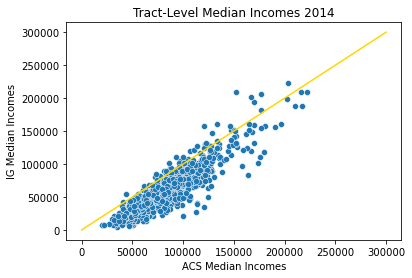

In [179]:
plt.title('Tract-Level Median Incomes ' + str(YEAR))
plt.xlabel('ACS Median Incomes')
plt.ylabel('IG Median Incomes')
x = np.linspace(0, 300000, 10000)
plt.plot(x, x, color='gold');
fig = sns.scatterplot(x='acs_medinc', y='ig_medinc', data=together)

In [180]:
fig = fig.get_figure()
fig.savefig('ig_income.png')

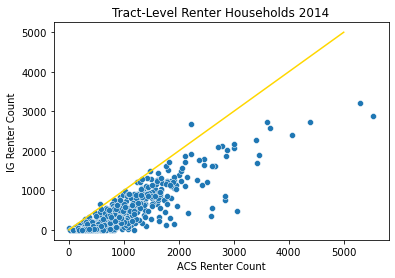

In [181]:
plt.title('Tract-Level Renter Households ' + str(YEAR))
plt.xlabel('ACS Renter Count')
plt.ylabel('IG Renter Count')
x = np.linspace(0, 5000, 10000)
plt.plot(x, x, color='gold');
fig = sns.scatterplot(x='acs_renters', y='ig_renters', data=together)

In [182]:
fig = fig.get_figure()
fig.savefig('ig_renter.png')

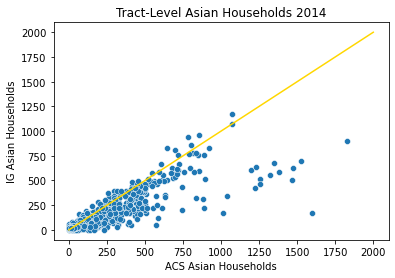

In [183]:
plt.title('Tract-Level Asian Households ' + str(YEAR))
plt.xlabel('ACS Asian Households')
plt.ylabel('IG Asian Households')
x = np.linspace(0, 2000, 10000)
plt.plot(x, x, color='gold');
fig = sns.scatterplot(x='acs_asian', y='ig_asian', data=together)

In [184]:
fig = fig.get_figure()
fig.savefig('ig_asian.png')

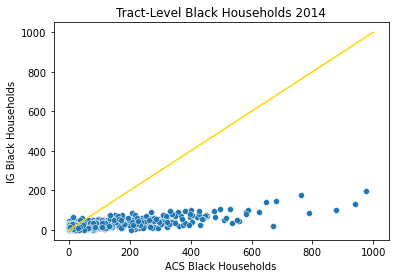

In [185]:
plt.title('Tract-Level Black Households ' + str(YEAR))
plt.xlabel('ACS Black Households')
plt.ylabel('IG Black Households')
x = np.linspace(0, 1000, 10000)
plt.plot(x, x, color='gold');
fig = sns.scatterplot(x='acs_black', y='ig_black', data=together)

In [186]:
fig = fig.get_figure()
fig.savefig('ig_black.png')

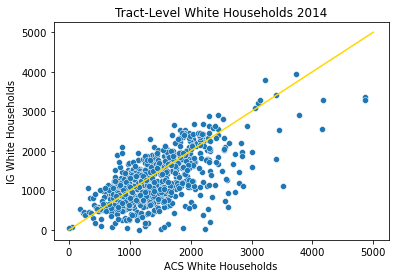

In [187]:
plt.title('Tract-Level White Households ' + str(YEAR))
plt.xlabel('ACS White Households')
plt.ylabel('IG White Households')
x = np.linspace(0, 5000, 10000)
plt.plot(x, x, color='gold');
fig = sns.scatterplot(x='acs_white', y='ig_white', data=together)

In [188]:
fig = fig.get_figure()
fig.savefig('ig_white.png')

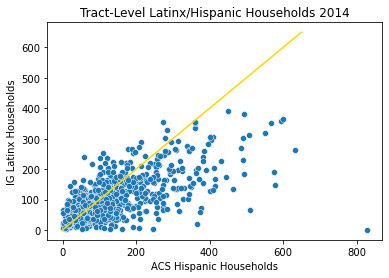

In [189]:
plt.title('Tract-Level Latinx/Hispanic Households ' + str(YEAR))
plt.xlabel('ACS Hispanic Households')
plt.ylabel('IG Latinx Households')
x = np.linspace(0, 650, 10000)
plt.plot(x, x, color='gold');
fig = sns.scatterplot(x='acs_hispanic', y='ig_latinx', data=together)

In [190]:
fig = fig.get_figure()
fig.savefig('ig_hispanic.png')